In [6]:
from fastbook import *
from fastai.vision.all import *
from nnAudio import features
from scipy.io import wavfile

In [7]:
sr, audio = wavfile.read('D:/oceanvue.fyp/DeepShip Dataset/Cargo/1/1.wav') # Loading your audio
(sr,audio.shape)

(32000, (14624000,))

In [8]:
waves = torch.tensor(audio).float() # casting the array into a PyTorch Tensor

In [9]:
waves.shape

torch.Size([14624000])

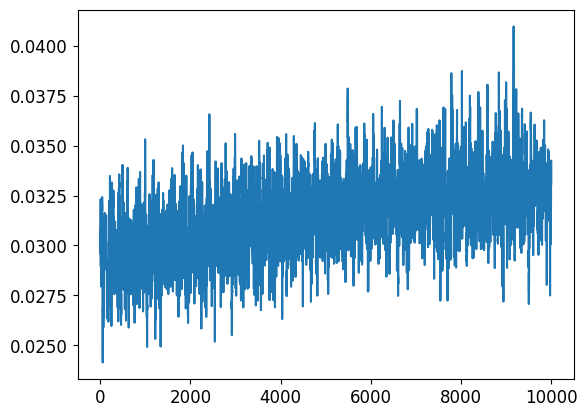

In [10]:
plt.plot(range(10000), waves[10000:20000])

Normalizing

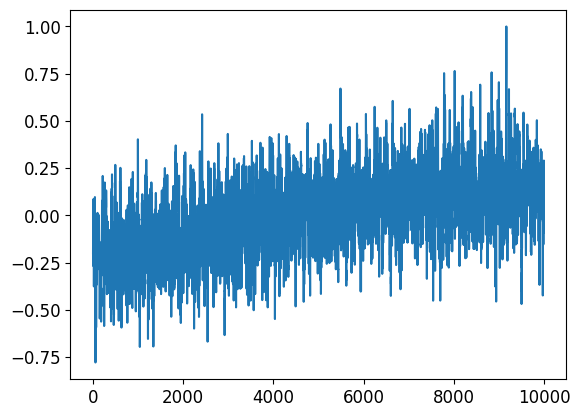

In [11]:
test = waves[10000:20000]
test = test - torch.mean(test)
test = test / max(test)
plt.plot(range(10000), test)

In [12]:
def normSamp(audio):
    ret = audio - torch.mean(audio)
    return ret / torch.max(ret)

def normSpec(spec):
    # take the logarithm of the values
    ret = torch.log10(spec)
    mean = torch.mean(ret)
    std = torch.std(ret)
    # Normalize each frame so its max 1, we dont need the extra dimension
    #return (ret / torch.transpose(torch.max(ret,2)[0],0,1))[0]
    #return (ret / torch.max(ret))[0]
    return  ((ret - mean) / (std*4) + 0.5)[0]

In [13]:
samples = normSamp(waves[0:4096*460*3])
img = features.STFT(n_fft=4096, freq_bins=None, hop_length=512,
                              window='hann', freq_scale='linear', center=True, pad_mode='constant',
                               output_format='Magnitude',
                              fmin=10,fmax=100, sr=32000)(samples)

sampling rate = 32000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.2504 seconds


In [14]:
img = normSpec(img)
img.shape

torch.Size([2049, 11041])

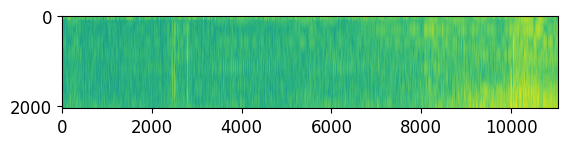

In [15]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


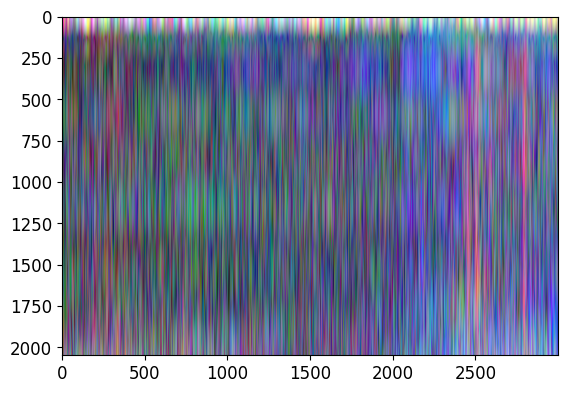

In [16]:
plt.imshow(torch.stack((img[:,0:3000],img[:,3000:6000],img[:,6000:9000]),-1))

-----------------------
Getting the spectograms

In order to get as much usefull data to the network, we can make images with different spectograms in each layer.
We can base our calculation on a image size of 460x460. Further we can select a random place in each sound clip for each batch, so we get more trainig data.

In speech analisys, frequencies below 50hz is not imortant. Therfor with traditinalo MEL spectorms this informatin is more or less discarded. This is bad for ship detection

In [17]:
imgsize  = 460

Fining out fft size (Nfft)
in order to catch a tone of 1hz the fft size needs to be at least equal to the samplerate. We find the nearest power of 2, becase fast fourier transfers are efficient at power of 2.

In [18]:
Nfft = pow(2,int(math.log(sr-1,2))+1)
Nfft

32768

Finding out how many samples we need (Nskip)
If we have no overlap between each fft, we need

In [19]:
Nfft * imgsize / sr

471.04

This is to much for some of the training data, and we will loose information between each fft frame. a better overlap is 80%, this gives us

In [20]:
Nfft*0.2 * imgsize /sr

94.208

In [21]:
Nskip = int(Nfft*0.2)
rng = int(Nfft*0.2 * imgsize)
(Nskip, rng)

(6553, 3014656)